# Реализации метода Нумерова для решения граничной задачи для уравнения Шредингера
В настоящей тетради производится вычисление энергии связанных состояний методом Нумерова и методом конечных разностей (второго порядка).

##Импорты
Импорт `scipy.linalg.lapack` и `scipy.linalg.lapack` - wrapper'ов для `LAPACK` и `BLAS`. Пакеты `numpy` и `matplotlib` используются для удобства вывода результатов и `seaborn` для красоты графиков. Для определения степени сходимости по наклону графика сходимости использутся `scipy.stats.linregress`.

In [11]:
from scipy.linalg import lapack, blas, eigvals_banded
from scipy.stats import linregress
import numpy as np

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

##Параметры сетки

In [2]:
N = 100
x_0 = 0.
x_max = 20.
h = (x_max - x_0)/N

##Потенциал Морзе

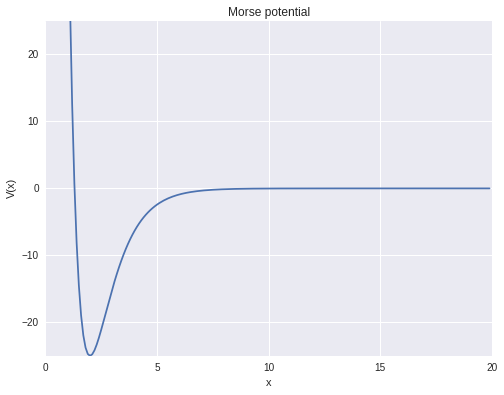

In [35]:
# Morse potential
morse_V = lambda x, kappa, x0: kappa**2*(np.exp(-2*(x-x0)) - 2*np.exp(-(x-x0)))
morse_E = lambda n, kappa: -(kappa - n - 0.5)**2
kappa = 5.
x0 = 2.

# Morse potential plotting
plt.figure(figsize=(8, 6))
x = np.arange(x_0, x_max, 0.1)
y = morse_V(x, kappa, x0)
plt.plot(x, y)
plt.ylim(min(y), -min(y))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Morse potential")
plt.show()

##Решение уравнения Шреденгера
###Метод Нумерова
* Заполнение трехдиагональных матриц A, B, V

In [4]:
def get_ABV(N, h, kappa, x0):
    A = [[0 for j in range(N)] for k in range(N)]
    B = [[0 for j in range(N)] for k in range(N)]
    V = [[0 for j in range(N)] for k in range(N)]

    for j in range(N):
        x = x_0 + h*j
        A[j][j] = 2/h**2
        B[j][j] = 10/12
        V[j][j] = morse_V(x, kappa, x0)
        if j > 0:
            A[j][j-1] = -1/h**2
            B[j][j-1] = 1/12
        if j < N-1:
            A[j][j+1] = -1/h**2
            B[j][j+1] = 1/12
    return A, B, V

A, B, V = get_ABV(N, h, kappa, x0)
print("\nFirst 3x3 block of A:\n", np.array(A)[:3,:3])
print("\nFirst 3x3 block of B:\n", np.array(B)[:3,:3])
print("\nFirst 3x3 block of V:\n", np.array(V)[:3,:3])



First 3x3 block of A:
 [[ 50. -25.   0.]
 [-25.  50. -25.]
 [  0. -25.  50.]]

First 3x3 block of B:
 [[ 0.83333333  0.08333333  0.        ]
 [ 0.08333333  0.83333333  0.08333333]
 [ 0.          0.08333333  0.83333333]]

First 3x3 block of V:
 [[ 995.50094588    0.            0.        ]
 [   0.          612.47348787    0.        ]
 [   0.            0.          365.66163371]]


* Формирование дискретного гамильтониана

In [27]:
def get_H_Numerov(A, B, V):
    lu, piv = lapack.dgetrf(B)[:2]
    inv_B = lapack.dgetri(lu, piv)[0]
    inv_BxA = blas.dgemm(1., inv_B, A)
    H_Numerov = [[inv_BxA[i][j] + V[i][j] for j in range(N)] for i in range(N)]
    return H_Numerov

H_Numerov = get_H_Numerov(A, B, V)
print("\nFirst 3x3 block of H_Numerov = inv_BxA + V:\n", np.array(H_Numerov)[:3, :3])


First 3x3 block of H_Numerov = inv_BxA + V:
 [[  1.05917480e+03  -3.67385196e+01   3.71134415e+00  -3.74921895e-01
    3.78748027e-02]
 [ -3.67385196e+01   6.79858684e+02  -3.71134415e+01   3.74921895e+00
   -3.78748027e-01]
 [  3.71134415e+00  -3.71134415e+01   4.33084705e+02  -3.71172676e+01
    3.74960547e+00]
 [ -3.74921895e-01   3.74921895e+00  -3.71172676e+01   2.75779628e+02
   -3.71173067e+01]
 [  3.78748027e-02  -3.78748027e-01   3.74960547e+00  -3.71173067e+01
    1.76997025e+02]]


* Решение обобщенной задачи на собственные значения

In [28]:
def get_sorted_egenvalues(H):
    H_data = np.zeros((2, len(H)))
    H_data[0,1:] = [H[j][j+1] for j in range(len(H)-1)]
    H_data[1,0:] = [H[j][j] for j in range(len(H))]
    #print(H[:3][:3])
    eigvalr = sorted(lapack.dgeev(H)[0])
    #eigvalr = eigvals_banded(H_data, select='i', select_range=(0,20))
    return eigvalr

eigvalr_Numerov = get_sorted_egenvalues(H_Numerov)
print('\nEigenvalues (Numerov method):')
for i in range(10):
    print('n =', i, ':', eigvalr_Numerov[i])


Eigenvalues (Numerov method):
n = 0 : -20.2514513669
n = 1 : -12.2558543172
n = 2 : -6.26065978886
n = 3 : -2.26091516116
n = 4 : -0.254678360857
n = 5 : 0.0571928770578
n = 6 : 0.217941055316
n = 7 : 0.467161531259
n = 8 : 0.795977140051
n = 9 : 1.19912538536


### Конечно-разностный метод
* Формирование дискретного гамильтониана

In [29]:
def get_H_FDM(A, B, V):
    H_FDM = [[A[i][j] + V[i][j] for j in range(N)] for i in range(N)]
    return H_FDM

H_FDM = get_H_FDM(A, B, V)
print("First 3x3 block of H_FDM = A + V:\n", np.array(H_FDM)[:3, :3])

First 3x3 block of H_FDM = A + V:
 [[ 1045.50094588   -25.             0.        ]
 [  -25.           662.47348787   -25.        ]
 [    0.           -25.           415.66163371]]


* Решение задачи на собственные значения

In [30]:
eigvalr_FDM = get_sorted_egenvalues(H_FDM)
print('\nEigenvalues (FDM):')
for i in range(10):
    print('n =', i, ':', eigvalr_FDM[i])


Eigenvalues (FDM):
n = 0 : -20.3051560467
n = 1 : -12.4347155568
n = 2 : -6.54085398315
n = 3 : -2.52795701237
n = 4 : -0.375965017382
n = 5 : 0.0495045332841
n = 6 : 0.196873768424
n = 7 : 0.43360089015
n = 8 : 0.750081495731
n = 9 : 1.13972964289


## Вывод графика с собственными значениями на фоне потенциала Морзе
На графике линиями с текстом отмечены связанные состояния. Свободные состояния указаны прозрачными линиями.

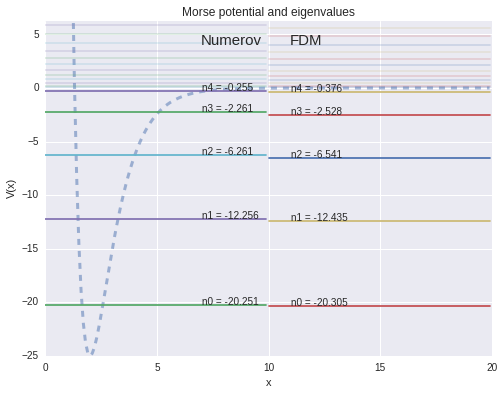

In [31]:
plt.figure(figsize=(8, 6))
x = np.arange(x_0, x_max, 0.1)
y = morse_V(x, kappa, x0)
plt.plot(x, y, '--',lw=3, alpha = 0.5)
plt.ylim(min(y), -min(y)/4)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Morse potential and eigenvalues")
for i in range(N):
    if eigvalr_Numerov[i]<0:
        plt.plot(x[:len(x)/2], [eigvalr_Numerov[i] for j in range(int(len(x)/2))], alpha = 1)
        plt.text(7, eigvalr_Numerov[i], "n%d = %.3f" % (i, eigvalr_Numerov[i]))
        plt.plot(x[len(x)/2:], [eigvalr_FDM[i] for j in range(int(len(x)/2))], alpha = 1)
        plt.text(11, eigvalr_FDM[i], "n%d = %.3f" % (i, eigvalr_FDM[i]))
    else:
        plt.plot(x[:len(x)/2], [eigvalr_Numerov[i] for j in range(int(len(x)/2))], alpha = 0.2)
        plt.plot(x[len(x)/2:], [eigvalr_FDM[i] for j in range(int(len(x)/2))], alpha = 0.2)

plt.text(7, 4, "Numerov", size=15)
plt.text(11, 4, "FDM", size=15)

## Сравнение скорости сходимости
* Вычисление собственных значений для различных значений N

In [32]:
N_list = [k for k in range(500, 2000, 200)]
ev_list_Numerov = []
ev_list_FDM = []
for N in N_list:
    h = (x_max - x_0)/N
    A, B, V = get_ABV(N, h, kappa, x0)
    ev_list_Numerov.append(get_sorted_egenvalues(get_H_Numerov(A, B, V)))
    ev_list_FDM.append(get_sorted_egenvalues(get_H_FDM(A, B, V)))

* Определение скоростей сходимости для наименьших двух связанных состояний

In [38]:
rate_Numerov = []
rate_FDM = []
for k in range(len(N_list)):
    rate_FDM.append(abs(ev_list_FDM[k][0]-morse_E(0, kappa)))
    rate_Numerov.append(abs(ev_list_Numerov[k][0]-morse_E(0, kappa)))

* Вывод графиков

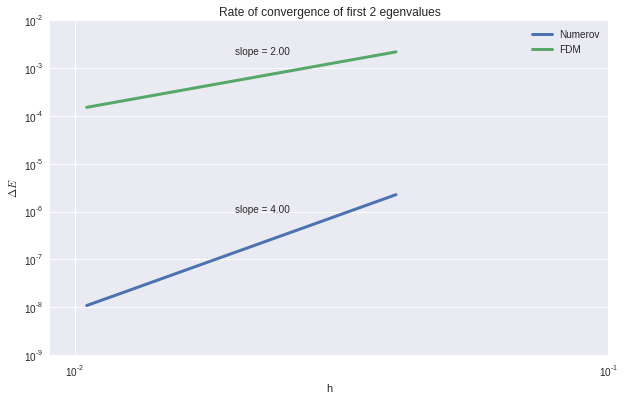

In [62]:
h_list = [(x_max - x_0)/N for N in N_list]
plt.figure(figsize=(10, 6))
plt.loglog(h_list[:], rate_Numerov, '-',lw=3)
plt.loglog(h_list[:], rate_FDM, '-',lw=3)
plt.legend(['Numerov', 'FDM'])
plt.xlim(.9e-2, 1e-1)
plt.ylim(1e-9, 1e-2)
slope_Numerov = linregress(np.log(h_list[:]), np.log(rate_Numerov))[0]
slope_FDM = linregress(np.log(h_list[:]), np.log(rate_FDM))[0]
plt.text(0.02, .2e-2, 'slope = %.2f' % slope_FDM)
plt.text(0.02, 1e-6, 'slope = %.2f' % slope_Numerov)
plt.xlabel('h')
plt.ylabel('${\Delta}E$')
plt.title('Rate of convergence of first 2 egenvalues')

Таким образом видно, что метод Нумерова является более точным чем конечноразностный метод 2-го порядка. Эксперементальная скорость сходимости для метода Нумерова равна примерно 4.0, для конечноразностного метода примерно 2.0, что согласуется с теоретическими сходимостями.